In [1]:
#imports
from pathlib import Path
import os
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
import sys

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import IPython.display as ipd
from matplotlib.pyplot import figure
import sox

from tqdm import tqdm

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [2]:
#https://pytorch.org/audio/stable/_modules/torchaudio/datasets/speechcommands.html
def load_speechcommands_item( path: str,filepath: str):
    label, filename = os.path.split(filepath)
    waveform, sample_rate = torchaudio.load(path +'/'+ filepath)
    return label, waveform, sample_rate
    
def _load_folder_list(root):
    return  list(str(p)[len(root)- 1:] for p in Path(root).glob("*/*.wav"))


class _SpeechSubset(Dataset):
    def __init__(self, root, subset, transformation = None):
        self.root = root
        self.subset = subset
        self.transformation = transformation
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        filepath = self.subset[idx]
        label, waveform, sample_rate = load_speechcommands_item(self.root, filepath)
        if self.transformation is not None:
            label, waveform, sample_rate = self.transformation(label, waveform, sample_rate)
        return waveform, sample_rate, label,
    

        
    

class SpeechDataset():
    def __init__(self, root, train_size = None, filter_name = None, transformation = None, ):
        self.root = root
        self.train_size = train_size
        self.transformation = transformation
        self.dataset = _load_folder_list(self.root)
        
        if filter_name is not None:
            self.dataset = [x for x in self.dataset if filter_name(x) == False]
            
        if self.train_size is not None:
            self.train_subset, self.val_subset = train_test_split(self.dataset, train_size=self.train_size)
     
    def __getSubset(self, name):
        if name == "train":
            return _SpeechSubset(self.root, self.train_subset, transformation = self.transformation)
        elif name == "val":
            return _SpeechSubset(self.root, self.val_subset, transformation = self.transformation)
        elif name == "train+val":
            return _SpeechSubset(self.root,  self.dataset, transformation = self.transformation)
        else:
            return None
            
    def getTrainSubset(self,):
        return self.__getSubset("train")
    
    def getValidationSubset(self):
        return self.__getSubset("val")
    
    def getTrainValidationSubset(self):
        return self.__getSubset("train+val")
    
    def getFilenames(self):
        return self.dataset

In [3]:
dataset_noise = SpeechDataset("./train/audio",None, filter_name = lambda x: x.startswith('_background_noise_') == False)

whole_set_noise = dataset_noise.getTrainValidationSubset()

In [4]:
#create silence
import random
import shutil

shutil.rmtree('./train/audio/silence', ignore_errors=True)
Path("./train/audio/silence").mkdir(parents=True, exist_ok=True)

low_sum_by_second = 0.5

max_ratio_level = 1
multiplication = 5


for z,(w,s,l) in enumerate(whole_set_noise):
    min_val = len(w[0]) / (s * float(w[0].abs().sum())) * low_sum_by_second
    step = (max_ratio_level - min_val) / multiplication
    print()
    for i in range(multiplication +1):
        ratio = min_val + step * i
        wave = w * ratio
        wave_split = wave.split(16000, dim = 1)
        for j,w1 in enumerate(wave_split):
            Path("./audio/silence").mkdir(parents=True, exist_ok=True)
            torchaudio.save('./train/audio/silence/'+str(z) + "_" +str(i) + "_" + str(j)+'.wav', w1, 16000)




In [6]:
dataset = SpeechDataset("./train/audio",0.7, filter_name = lambda x: x.startswith('_background_noise_'))

train_set = dataset.getTrainSubset()
val_set = dataset.getValidationSubset()
whole_set = dataset.getTrainValidationSubset()

In [8]:
labels =['zero',
  'on',
  'bed',
  'off',
  'stop',
  'up',
  'six',
  'bird',
  'no',
  'house',
  'three',
  'dog',
  'five',
  'silence',
  'tree',
  'left',
  'nine',
  'marvin',
  'one',
  'wow',
  'right',
  'yes',
  'eight',
  'go',
  'down',
  'cat',
  'four',
  'two',
  'seven',
  'sheila',
  'happy']


In [9]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(21) --> yes


In [10]:
softmax = torch.load("tensor.pt")

In [24]:
len(softmax)

46993

In [17]:
softmax.max(dim = 1)[0].argmin()

tensor(43240)

In [30]:
softmax.max(dim = 1)[0][43240]

tensor(0.0801)

In [28]:
 a = softmax.max(dim = 1)[0].numpy()
 

In [37]:
b = a < 0.7

In [38]:
b.sum()

978

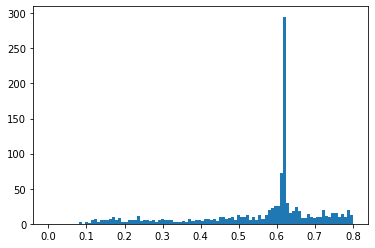

In [31]:
import matplotlib.pyplot as plt
plt.hist(a, bins = 100,range=(0,0.8))
plt.show()

In [25]:
len(train_set)

46993

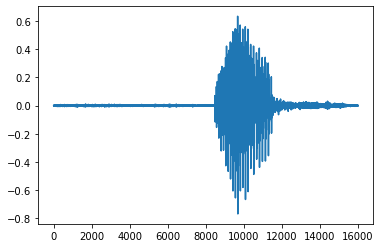

In [20]:
w = train_set[43240][0]
plt.plot(w.t().numpy())
plt.show()


In [21]:
filenames = dataset_noise.getFilenames()

In [23]:
len(filenames)

6

In [5]:
import random

class RandomSpeedChange:
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate

    def __call__(self, audio_data):
        speed_factor = random.choice([0.6, 1.0, 1.9])
        if speed_factor == 1.0: # no change
            return audio_data

        # change speed and resample to original rate:
        sox_effects = [
            ["speed", str(speed_factor)],
            ["rate", str(self.sample_rate)],
        ]
        transformed_audio, _ = torchaudio.sox_effects.apply_effects_tensor(
            audio_data, self.sample_rate, sox_effects)
        return transformed_audio
 
# speed_transform = RandomSpeedChange(sample_rate)
# transformed_audio = speed_transform(audio_data)

In [6]:
novi = []
for w,s,l in whole_set:
    speed_transform = RandomSpeedChange(s)
    novi.append(speed_transform(w))

for n in novi:
    plt.plot(n.t().numpy())
    plt.show()

RuntimeError: torchaudio.sox_effects.sox_effects.apply_effects_tensor requires sox